### **Problem**

This project aims to automate multi-label classification of disaster-related tweets using advanced natural language processing (NLP) models. The tweets, collected during hurricane events such as Harvey, Imelda, and Beryl, contain critical information ranging from property damage to requests for assistance. Manual annotation of such large-scale data is infeasible and time-consuming. Hence, there is a need for an efficient and scalable method to identify multiple categories of disaster impact from tweet content, enabling timely and informed disaster response decisions.

---

### **Objectives**

* Understand the underlying structure of multi-label text classification.
* Implement a custom PyTorch dataset and data preprocessing pipeline using geolocation and tweet metadata.
* Train a BERT-based multi-head neural network to predict 11 disaster impact categories.
* Apply k-fold cross-validation to ensure robust model evaluation.
* Use ensemble modeling strategies (in-domain, cross-domain, two-source, and three-source) to analyze model generalization across different hurricanes.
* Generate performance metrics such as Accuracy, Precision, Recall, and F1-Score for each label and average performance.
* Save the best model per fold and use ensemble predictions to improve reliability.



### 1. Import Required Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import math
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

This imports all necessary libraries:
- `os` for file operations
- `torch` for deep learning framework
- `transformers` for BERT model
- `Dataset` and `DataLoader` for handling data
- `KFold` for cross-validation
- Metrics from `sklearn` for evaluation
- `pandas` and `numpy` for data handling
- `tqdm` for progress bars
- `math` for geolocation calculations


### 2. Set Device and Reproducibility Seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(64)

- Sets the device to GPU if available, otherwise CPU
- Fixes random seed (64) for reproducibility

### 3. Define Save Path for Model Outputs


In [3]:
save_path = 'Training_results/Harvey_5foldcv_BERT_Multihead_Deeper_512/'
os.makedirs(save_path, exist_ok=True)

- Defines where to save model checkpoints and results
- Creates directory if it doesn't exist

### 4. Load BERT Tokenizer and Model


In [4]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = transformers.BertModel.from_pretrained('bert-base-uncased')

- Loads BERT tokenizer and base model (uncased version)
- Will be used for text processing and feature extraction

### 5. Define Geolocation Utility Functions

In [5]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3959  
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def get_box_area(lat1, lon1, lat2, lon2):
    side1 = haversine(lat1, lon1, lat1, lon2)
    side2 = haversine(lat1, lon1, lat2, lon1)
    return side1 * side2

- `haversine()` calculates distance between two geographic points
- `get_box_area()` computes area of a bounding box
- Used for filtering tweets by spatial relevance

### 6. Define Default Target List

In [6]:
def get_target_list(target_list=[]):
    if not target_list:
        target_list = [
            'homeOwnersInsurance', 'floodInsurance', 'destroyed', 'floodDamage', 'roofDamage', 
            'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
            'replacementAssistanceEligible', 'personalPropertyEligible'
        ]
    return target_list

- Returns list of 11 disaster impact categories
- Used for multi-label classification

### 7. Define Custom Dataset Class

In [7]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

- Handles tokenization and formatting of text data
- Converts text to BERT-compatible input format
- Returns dictionary with input IDs, attention masks, and labels

### 8. Define BERT Multi-Head Classification Model


In [8]:
class BERTMultiDeepHeadClassifier(nn.Module):
    def __init__(self, num_targets=11):
        super(BERTMultiDeepHeadClassifier, self).__init__()
        self.bert = model_bert
        self.drop = nn.Dropout(0.3)
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.bert.config.hidden_size, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 1),
                nn.Sigmoid()
            ) for _ in range(num_targets)
        ])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.drop(outputs.pooler_output)
        return torch.cat([head(pooled_output) for head in self.heads], dim=1)

- Custom BERT model with separate deep heads for each target
- Each head has 3 linear layers with ReLU activation and dropout
- Final sigmoid activation for binary classification

### 9. Define K-Fold Cross-Validation Training Function

In [9]:
def kfoldcv(grouped_tweets, grouped_targets, target_list=[], max_len=256, batch_size=32, num_epochs=10, patience=15):
    saved_models = []
    target_list = get_target_list(target_list)
    
    tweet_dict = {int(name): group['text'] for name, group in grouped_tweets}
    target_dict = {int(name): group[target_list] for name, group in grouped_targets}
    
    intersecting_zips = list(set(target_dict.keys()) & set(tweet_dict.keys()))
    paired_data = {
        name: [target_dict[name].sum().apply(lambda x: 1 if x > 0 else 0), tweet_dict[name]] for name in intersecting_zips
    }
    
    texts = ['\n'.join(v[1].to_list()) for v in paired_data.values()]
    labels_ = [v[0] for v in paired_data.values()]
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    best_f1 = -float('inf')
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(texts, labels_)):
        print(f"Training fold {fold + 1}...")

        X_train, X_test = [texts[i] for i in train_idx], [texts[i] for i in test_idx]
        y_train, y_test = [labels_[i] for i in train_idx], [labels_[i] for i in test_idx]
        
        train_dataset = CustomDataset(X_train, y_train, tokenizer, max_len)
        test_dataset = CustomDataset(X_test, y_test, tokenizer, max_len)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model = BERTMultiDeepHeadClassifier(num_targets=len(target_list)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-5)
        criterion = nn.BCELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
        
        early_stop_count = 0
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch_f1 = 0
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            train_preds, train_labels = [], []
            
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
                for batch in tepoch:
                    optimizer.zero_grad()
                    
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids, attention_mask)
                    loss = sum([criterion(outputs[:, i], labels[:, i]) for i in range(len(target_list))])
                    
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                    
                    tepoch.set_postfix(loss=loss.item())
                    
                    train_preds.append(outputs.detach().cpu().numpy())
                    train_labels.append(labels.cpu().numpy())
            
            train_preds = np.vstack(train_preds)
            train_labels = np.vstack(train_labels)
            
            model.eval()
            val_loss = 0
            val_preds, val_labels = [], []
            
            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Validating", unit="batch"):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids, attention_mask)
                    loss = sum([criterion(outputs[:, i], labels[:, i]) for i in range(len(target_list))])
                    
                    val_loss += loss.item()
                    val_preds.append(outputs.cpu().numpy())
                    val_labels.append(labels.cpu().numpy())
            
            val_preds = np.vstack(val_preds)
            val_labels = np.vstack(val_labels)
            
            f1 = np.mean([f1_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            accuracy = np.mean([accuracy_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            precision = np.mean([precision_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            recall = np.mean([recall_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
            
            scheduler.step(f1)
            
            if f1 > best_epoch_f1:
                best_epoch_f1 = f1
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count >= patience:
                    print("Early stopping triggered.")
                    break
        
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), os.path.join(save_path, f"bert_model_fold_{fold+1}.pth"))
        saved_models.append(model)

- Implements 5-fold cross-validation
- Trains separate model for each fold
- Uses early stopping based on validation F1 score
- Saves best model for each fold

### 10. Load and Preprocess Data & Start Training

In [10]:
size_threshold = 80

# Load and preprocess Harvey tweets
tweets_harvey2 = pd.read_csv('harvey_corrected.csv')
tweets_harvey2.rename(columns={'zipcode': 'zip_code'}, inplace=True)

# Filter tweets by geographic relevance
bboxes_useful = tweets_harvey2.place_bbox.apply(lambda x: [[float(i.strip('()[]')) for i in x.split(', ')][i] for i in [1,0,3,2]])
bbu_areas = bboxes_useful.apply(lambda x: get_box_area(*x))
tweets_harvey = tweets_harvey2.loc[((tweets_harvey2.geo.apply(lambda x: 'Point' in str(x))) | (bbu_areas < size_threshold)), :]
tweets_harvey.loc[:, 'zip_code'] = tweets_harvey['zip_code'].apply(int)
tweet_grouped_harvey = tweets_harvey.groupby('zip_code')

# Load target data
targets_harvey = pd.read_csv('disaster_4332.csv')
target_grouped_harvey = targets_harvey.groupby('damagedZipCode')

# Start training
kfoldcv(tweet_grouped_harvey, target_grouped_harvey, max_len=512, batch_size=24, num_epochs=100)

/tmp/job.15638628/ipykernel_2188514/3791959303.py:15: DtypeWarning: Columns (9,10,13,28,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  targets_harvey = pd.read_csv('disaster_4332.csv')


Training fold 1...


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.41batch/s]


Epoch 1: Train Loss: 105.5720, Val Loss: 29.7968, F1: 0.5772, Accuracy: 0.6508, Precision: 0.5274, Recall: 0.6921


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.42batch/s]


Epoch 2: Train Loss: 103.7407, Val Loss: 29.0832, F1: 0.6401, Accuracy: 0.6796, Precision: 0.5284, Recall: 0.8164


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44batch/s]


Epoch 3: Train Loss: 101.2752, Val Loss: 28.4304, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 4: Train Loss: 99.3522, Val Loss: 27.8599, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 5: Train Loss: 97.5181, Val Loss: 27.4571, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 6: Train Loss: 96.7550, Val Loss: 27.1484, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 7: Train Loss: 95.9770, Val Loss: 27.0322, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 8: Train Loss: 95.1788, Val Loss: 26.9434, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44batch/s]


Epoch 9: Train Loss: 95.4286, Val Loss: 26.8736, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44batch/s]


Epoch 10: Train Loss: 95.0072, Val Loss: 26.8482, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 11: Train Loss: 94.7676, Val Loss: 26.8189, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 12: Train Loss: 94.6695, Val Loss: 26.7966, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 13: Train Loss: 94.3741, Val Loss: 26.7921, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44batch/s]


Epoch 14: Train Loss: 94.3007, Val Loss: 26.7857, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44batch/s]


Epoch 15: Train Loss: 94.8526, Val Loss: 26.7621, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.45batch/s]


Epoch 16: Train Loss: 94.1345, Val Loss: 26.7583, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.43batch/s]


Epoch 17: Train Loss: 93.5939, Val Loss: 26.7583, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:01<00:00,  2.44batch/s]


Epoch 18: Train Loss: 93.9754, Val Loss: 26.7565, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182
Early stopping triggered.
Training fold 2...


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.96batch/s]


Epoch 1: Train Loss: 104.8836, Val Loss: 29.2031, F1: 0.6522, Accuracy: 0.6918, Precision: 0.5466, Recall: 0.8133


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]


Epoch 2: Train Loss: 102.2100, Val Loss: 28.4761, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 3: Train Loss: 100.2017, Val Loss: 27.8028, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 4: Train Loss: 98.4370, Val Loss: 27.2180, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 5: Train Loss: 97.1588, Val Loss: 26.7787, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 6: Train Loss: 96.2540, Val Loss: 26.5444, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 7: Train Loss: 95.1651, Val Loss: 26.3270, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 8: Train Loss: 93.3860, Val Loss: 26.3190, F1: 0.6511, Accuracy: 0.6929, Precision: 0.5484, Recall: 0.8059


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 9: Train Loss: 91.4437, Val Loss: 26.0712, F1: 0.6545, Accuracy: 0.7007, Precision: 0.5548, Recall: 0.8028


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 10: Train Loss: 90.0770, Val Loss: 26.3468, F1: 0.6514, Accuracy: 0.7162, Precision: 0.5864, Recall: 0.7425


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 11: Train Loss: 88.5708, Val Loss: 25.6839, F1: 0.6697, Accuracy: 0.7417, Precision: 0.5975, Recall: 0.7658


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 12: Train Loss: 86.7460, Val Loss: 25.6317, F1: 0.6642, Accuracy: 0.7494, Precision: 0.6248, Recall: 0.7110


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 13: Train Loss: 85.0830, Val Loss: 25.2624, F1: 0.6748, Accuracy: 0.7605, Precision: 0.6260, Recall: 0.7338


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.96batch/s]


Epoch 14: Train Loss: 83.7361, Val Loss: 25.3477, F1: 0.6630, Accuracy: 0.7517, Precision: 0.6330, Recall: 0.6975


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 15: Train Loss: 81.7264, Val Loss: 24.8043, F1: 0.6721, Accuracy: 0.7539, Precision: 0.6162, Recall: 0.7404


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 16: Train Loss: 81.0254, Val Loss: 25.4826, F1: 0.6344, Accuracy: 0.7373, Precision: 0.6689, Recall: 0.6074


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 17: Train Loss: 79.2188, Val Loss: 24.4441, F1: 0.6759, Accuracy: 0.7605, Precision: 0.6226, Recall: 0.7404


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 18: Train Loss: 77.4654, Val Loss: 24.8648, F1: 0.6509, Accuracy: 0.7428, Precision: 0.6394, Recall: 0.6649


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 19: Train Loss: 77.2980, Val Loss: 24.5015, F1: 0.6665, Accuracy: 0.7528, Precision: 0.6269, Recall: 0.7130


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.96batch/s]


Epoch 20: Train Loss: 76.0859, Val Loss: 24.3926, F1: 0.6675, Accuracy: 0.7550, Precision: 0.6299, Recall: 0.7112


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 21: Train Loss: 75.3512, Val Loss: 24.3855, F1: 0.6665, Accuracy: 0.7561, Precision: 0.6352, Recall: 0.7025


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 22: Train Loss: 74.8397, Val Loss: 24.3667, F1: 0.6656, Accuracy: 0.7550, Precision: 0.6350, Recall: 0.7010


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 23: Train Loss: 74.5883, Val Loss: 24.1323, F1: 0.6742, Accuracy: 0.7616, Precision: 0.6298, Recall: 0.7267


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 24: Train Loss: 74.0155, Val Loss: 24.3386, F1: 0.6658, Accuracy: 0.7550, Precision: 0.6340, Recall: 0.7025


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 25: Train Loss: 73.2087, Val Loss: 24.2893, F1: 0.6709, Accuracy: 0.7605, Precision: 0.6347, Recall: 0.7127


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 26: Train Loss: 73.8856, Val Loss: 24.3775, F1: 0.6598, Accuracy: 0.7483, Precision: 0.6316, Recall: 0.6919


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 27: Train Loss: 73.6474, Val Loss: 24.3658, F1: 0.6569, Accuracy: 0.7450, Precision: 0.6306, Recall: 0.6870


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 28: Train Loss: 73.0309, Val Loss: 24.3005, F1: 0.6618, Accuracy: 0.7506, Precision: 0.6323, Recall: 0.6954


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 29: Train Loss: 72.8630, Val Loss: 24.1811, F1: 0.6719, Accuracy: 0.7605, Precision: 0.6324, Recall: 0.7180


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 30: Train Loss: 73.2657, Val Loss: 24.1455, F1: 0.6713, Accuracy: 0.7594, Precision: 0.6313, Recall: 0.7180


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.95batch/s]


Epoch 31: Train Loss: 72.7419, Val Loss: 24.1543, F1: 0.6719, Accuracy: 0.7605, Precision: 0.6324, Recall: 0.7180


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.96batch/s]


Epoch 32: Train Loss: 73.7899, Val Loss: 24.1865, F1: 0.6713, Accuracy: 0.7605, Precision: 0.6340, Recall: 0.7144
Early stopping triggered.
Training fold 3...


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 1: Train Loss: 103.9852, Val Loss: 28.2897, F1: 0.7143, Accuracy: 0.7916, Precision: 0.6958, Recall: 0.7452


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 2: Train Loss: 98.5018, Val Loss: 26.6791, F1: 0.7286, Accuracy: 0.8248, Precision: 0.7131, Recall: 0.7466


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 3: Train Loss: 92.5595, Val Loss: 25.2095, F1: 0.7449, Accuracy: 0.8503, Precision: 0.7509, Recall: 0.7418


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 4: Train Loss: 86.8225, Val Loss: 23.5260, F1: 0.7404, Accuracy: 0.8370, Precision: 0.6987, Recall: 0.7881


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 5: Train Loss: 81.6857, Val Loss: 22.5167, F1: 0.7356, Accuracy: 0.8293, Precision: 0.6902, Recall: 0.7881


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 6: Train Loss: 76.1502, Val Loss: 21.2743, F1: 0.7551, Accuracy: 0.8647, Precision: 0.7651, Recall: 0.7482


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 7: Train Loss: 71.5280, Val Loss: 20.6701, F1: 0.7480, Accuracy: 0.8559, Precision: 0.7644, Recall: 0.7354


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 8: Train Loss: 65.1325, Val Loss: 19.0132, F1: 0.7589, Accuracy: 0.8692, Precision: 0.7625, Recall: 0.7578


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 9: Train Loss: 61.2975, Val Loss: 19.2034, F1: 0.7426, Accuracy: 0.8492, Precision: 0.7639, Recall: 0.7258


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 10: Train Loss: 57.1998, Val Loss: 19.4085, F1: 0.7313, Accuracy: 0.8337, Precision: 0.7487, Recall: 0.7178


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 11: Train Loss: 53.5956, Val Loss: 19.7624, F1: 0.7235, Accuracy: 0.8137, Precision: 0.6890, Recall: 0.7625


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 12: Train Loss: 49.0855, Val Loss: 19.7233, F1: 0.7235, Accuracy: 0.8137, Precision: 0.6890, Recall: 0.7625


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 13: Train Loss: 47.4046, Val Loss: 19.6142, F1: 0.7304, Accuracy: 0.8226, Precision: 0.6898, Recall: 0.7768


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]


Epoch 14: Train Loss: 45.7243, Val Loss: 19.0299, F1: 0.7338, Accuracy: 0.8304, Precision: 0.7082, Recall: 0.7625


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 15: Train Loss: 44.7479, Val Loss: 19.1865, F1: 0.7289, Accuracy: 0.8226, Precision: 0.6991, Recall: 0.7625


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s]


Epoch 16: Train Loss: 44.6378, Val Loss: 19.4306, F1: 0.7303, Accuracy: 0.8226, Precision: 0.6908, Recall: 0.7753


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 17: Train Loss: 43.2264, Val Loss: 19.5943, F1: 0.7258, Accuracy: 0.8171, Precision: 0.6907, Recall: 0.7656


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 18: Train Loss: 43.2482, Val Loss: 19.8774, F1: 0.7159, Accuracy: 0.8060, Precision: 0.6959, Recall: 0.7386


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 19: Train Loss: 42.3538, Val Loss: 19.7895, F1: 0.7176, Accuracy: 0.8082, Precision: 0.6963, Recall: 0.7415


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 20: Train Loss: 41.6873, Val Loss: 19.7916, F1: 0.7190, Accuracy: 0.8082, Precision: 0.6889, Recall: 0.7528


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 21: Train Loss: 41.3463, Val Loss: 19.8261, F1: 0.7225, Accuracy: 0.8126, Precision: 0.6898, Recall: 0.7593


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]


Epoch 22: Train Loss: 41.4342, Val Loss: 19.7787, F1: 0.7197, Accuracy: 0.8093, Precision: 0.6902, Recall: 0.7528


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]


Epoch 23: Train Loss: 41.3304, Val Loss: 19.7933, F1: 0.7190, Accuracy: 0.8082, Precision: 0.6889, Recall: 0.7528
Early stopping triggered.
Training fold 4...


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 1: Train Loss: 102.2760, Val Loss: 27.0367, F1: 0.8429, Accuracy: 0.9113, Precision: 0.8226, Recall: 0.8858


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 2: Train Loss: 93.9182, Val Loss: 24.6540, F1: 0.8390, Accuracy: 0.9113, Precision: 0.8448, Recall: 0.8508


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.98batch/s]


Epoch 3: Train Loss: 86.6187, Val Loss: 22.4330, F1: 0.8456, Accuracy: 0.9203, Precision: 0.8450, Recall: 0.8618


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 4: Train Loss: 79.2923, Val Loss: 20.6663, F1: 0.7815, Accuracy: 0.9147, Precision: 0.8031, Recall: 0.7637


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.98batch/s]


Epoch 5: Train Loss: 73.1770, Val Loss: 19.3409, F1: 0.7757, Accuracy: 0.9080, Precision: 0.8028, Recall: 0.7530


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 6: Train Loss: 68.3924, Val Loss: 17.1418, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 7: Train Loss: 63.5414, Val Loss: 16.4460, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 8: Train Loss: 59.8846, Val Loss: 15.7815, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.98batch/s]


Epoch 9: Train Loss: 57.3993, Val Loss: 15.1302, F1: 0.7885, Accuracy: 0.9226, Precision: 0.8016, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 10: Train Loss: 55.5136, Val Loss: 14.8271, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.98batch/s]


Epoch 11: Train Loss: 54.1634, Val Loss: 14.5482, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 12: Train Loss: 52.8382, Val Loss: 14.2627, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 13: Train Loss: 52.0965, Val Loss: 14.1334, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 14: Train Loss: 52.1857, Val Loss: 14.0303, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 15: Train Loss: 51.1426, Val Loss: 13.9019, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 16: Train Loss: 50.6709, Val Loss: 13.8604, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 17: Train Loss: 50.8476, Val Loss: 13.8539, F1: 0.7892, Accuracy: 0.9237, Precision: 0.8033, Recall: 0.7785


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.99batch/s]


Epoch 18: Train Loss: 49.6543, Val Loss: 14.0493, F1: 0.7815, Accuracy: 0.9147, Precision: 0.8031, Recall: 0.7637
Early stopping triggered.
Training fold 5...


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 1: Train Loss: 103.0788, Val Loss: 27.8947, F1: 0.7701, Accuracy: 0.8664, Precision: 0.7502, Recall: 0.8026


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 2: Train Loss: 95.2041, Val Loss: 25.6237, F1: 0.7608, Accuracy: 0.8709, Precision: 0.7335, Recall: 0.7956


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 3: Train Loss: 87.4723, Val Loss: 23.6228, F1: 0.7749, Accuracy: 0.8956, Precision: 0.7574, Recall: 0.7939


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 4: Train Loss: 81.2078, Val Loss: 21.8004, F1: 0.7764, Accuracy: 0.8967, Precision: 0.7509, Recall: 0.8039


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 5: Train Loss: 75.1065, Val Loss: 20.4293, F1: 0.7738, Accuracy: 0.8923, Precision: 0.7447, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 6: Train Loss: 68.1301, Val Loss: 18.8572, F1: 0.7729, Accuracy: 0.8923, Precision: 0.7534, Recall: 0.7938


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 7: Train Loss: 62.3453, Val Loss: 17.6013, F1: 0.7729, Accuracy: 0.8923, Precision: 0.7534, Recall: 0.7938


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 8: Train Loss: 58.8671, Val Loss: 17.0498, F1: 0.7729, Accuracy: 0.8923, Precision: 0.7534, Recall: 0.7938


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 9: Train Loss: 56.3394, Val Loss: 16.5860, F1: 0.7741, Accuracy: 0.8945, Precision: 0.7573, Recall: 0.7922


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 10: Train Loss: 54.2631, Val Loss: 16.1230, F1: 0.7736, Accuracy: 0.8934, Precision: 0.7547, Recall: 0.7938


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 11: Train Loss: 51.9624, Val Loss: 15.9180, F1: 0.7734, Accuracy: 0.8934, Precision: 0.7559, Recall: 0.7922


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 12: Train Loss: 51.0027, Val Loss: 15.7084, F1: 0.7729, Accuracy: 0.8923, Precision: 0.7534, Recall: 0.7938


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 13: Train Loss: 49.6187, Val Loss: 15.5219, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 14: Train Loss: 48.8121, Val Loss: 15.4397, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 15: Train Loss: 48.0337, Val Loss: 15.3619, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 16: Train Loss: 47.2109, Val Loss: 15.2813, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 17: Train Loss: 46.3316, Val Loss: 15.1898, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 18: Train Loss: 46.7259, Val Loss: 15.1610, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 19: Train Loss: 46.8647, Val Loss: 15.1495, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 20: Train Loss: 46.2498, Val Loss: 15.0845, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 21: Train Loss: 45.5389, Val Loss: 15.0551, F1: 0.7759, Accuracy: 0.8956, Precision: 0.7486, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 22: Train Loss: 45.2087, Val Loss: 15.0260, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 23: Train Loss: 45.4314, Val Loss: 14.9948, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 24: Train Loss: 45.6462, Val Loss: 14.9886, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 25: Train Loss: 45.5815, Val Loss: 14.9937, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 26: Train Loss: 45.0245, Val Loss: 14.9786, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 27: Train Loss: 44.9285, Val Loss: 14.9682, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 28: Train Loss: 45.4769, Val Loss: 14.9618, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 29: Train Loss: 45.3361, Val Loss: 14.9567, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.89batch/s]


Epoch 30: Train Loss: 44.9411, Val Loss: 14.9530, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 31: Train Loss: 45.1668, Val Loss: 14.9479, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054


Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]


Epoch 32: Train Loss: 45.1348, Val Loss: 14.9420, F1: 0.7765, Accuracy: 0.8967, Precision: 0.7498, Recall: 0.8054
Early stopping triggered.


- Loads and preprocesses tweet data
- Filters tweets by geographic bounding box size
- Groups data by zip code
- Loads target labels
- Starts 5-fold cross-validation training

### 11. Evaluation and Visualization


Evaluating fold 1...


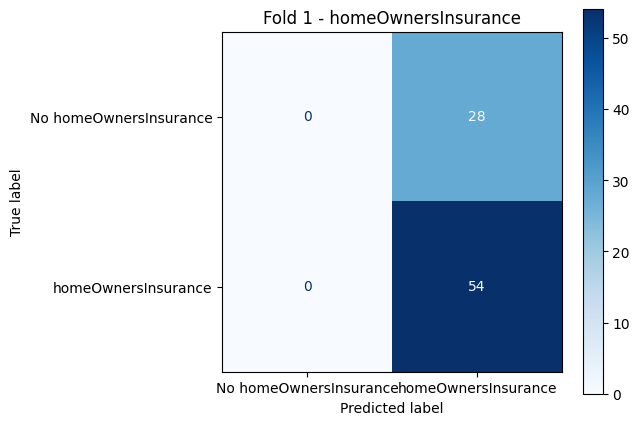

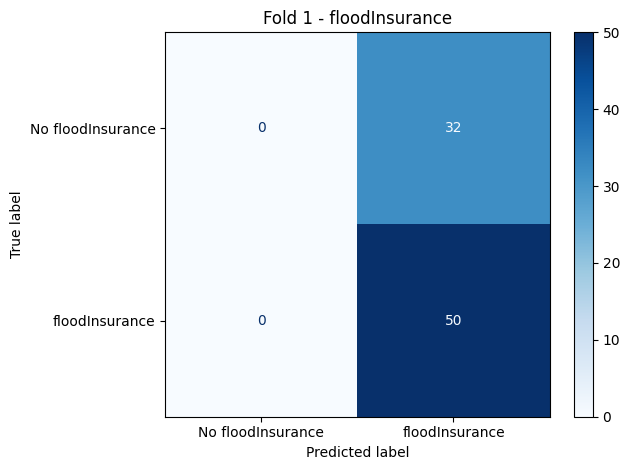

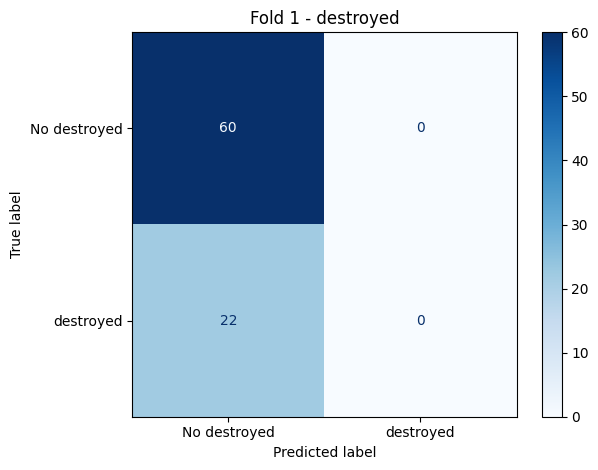

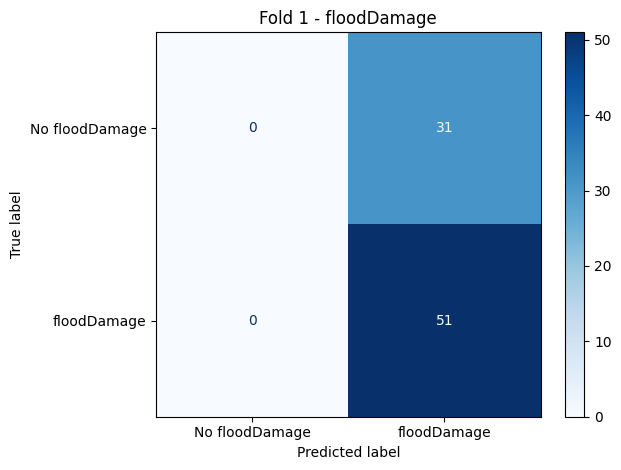

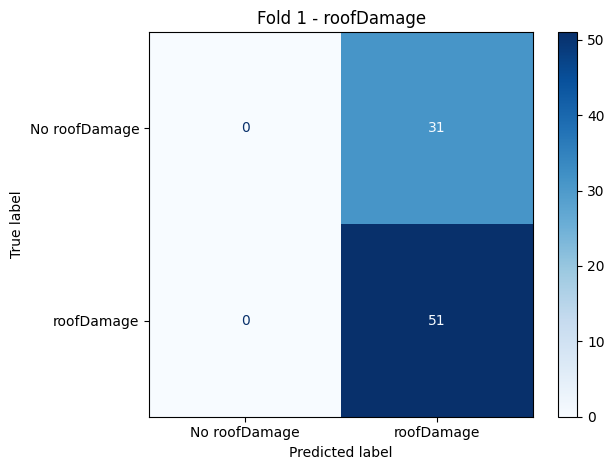

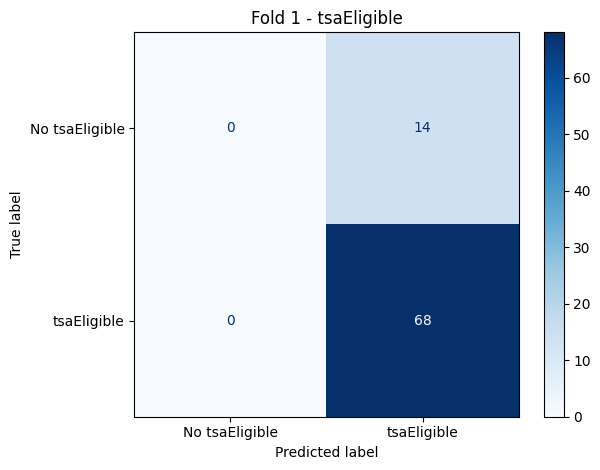

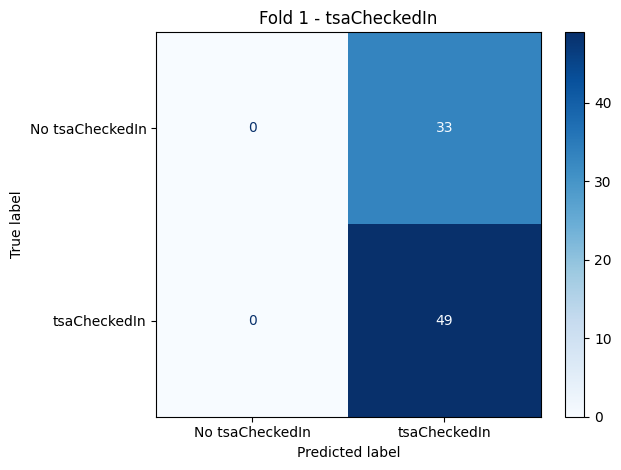

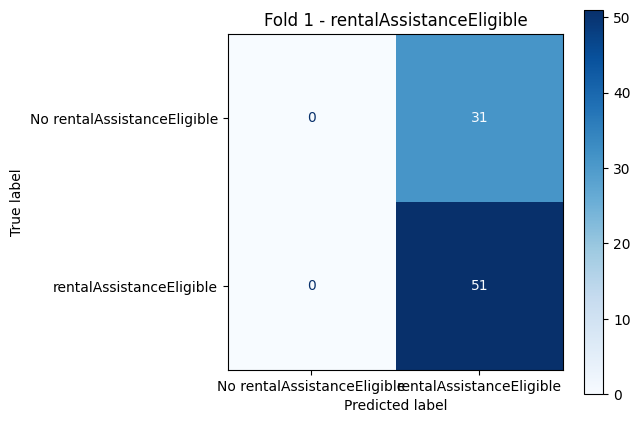

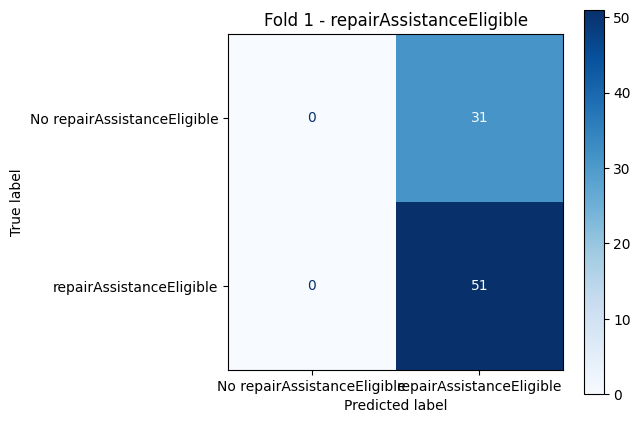

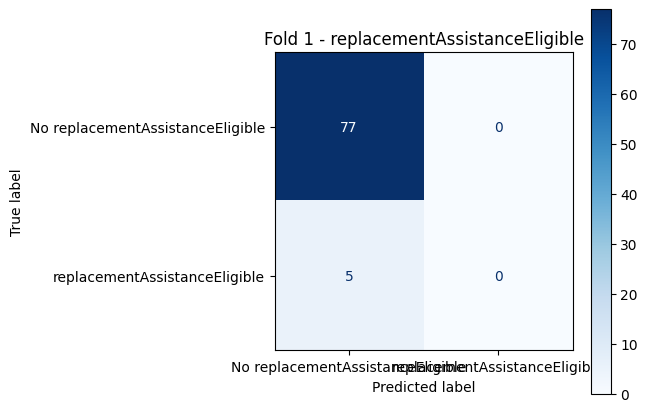

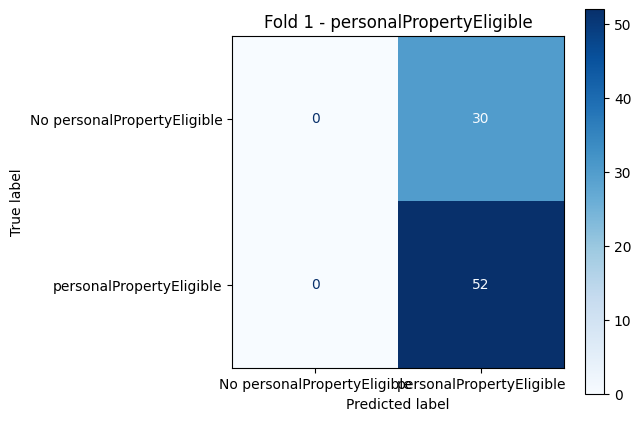


Evaluating fold 2...


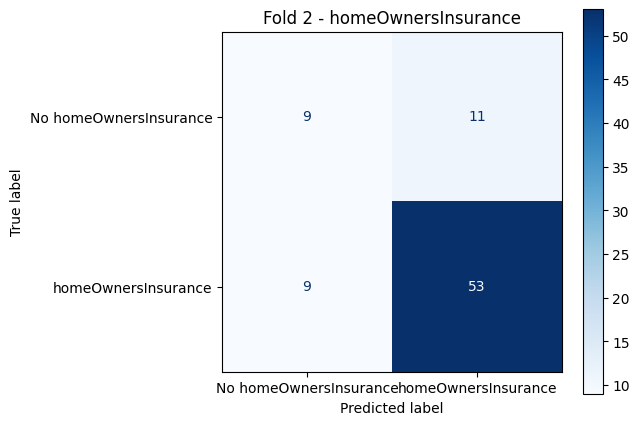

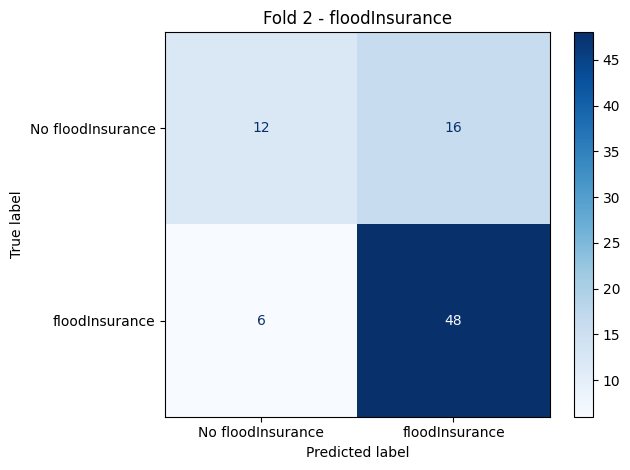

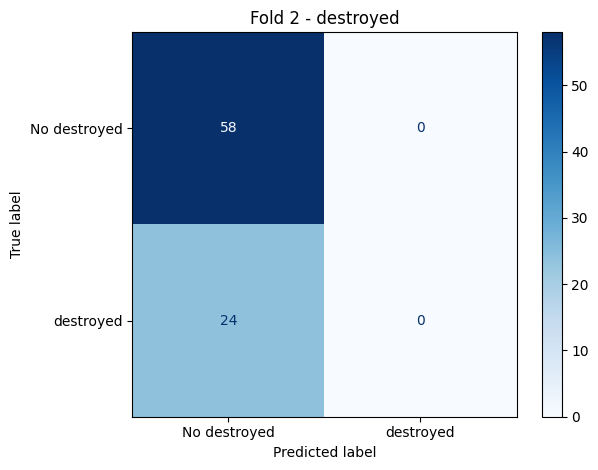

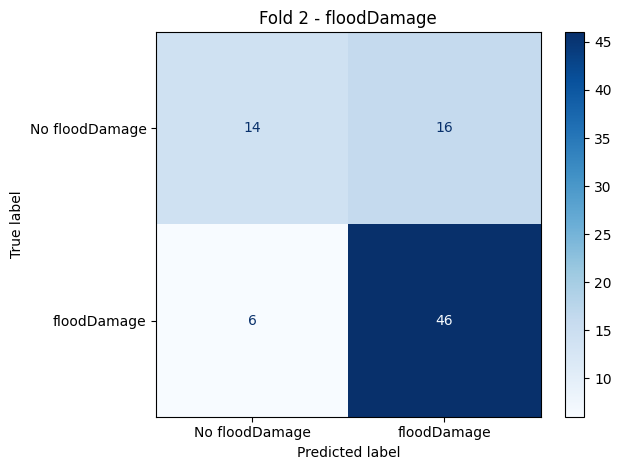

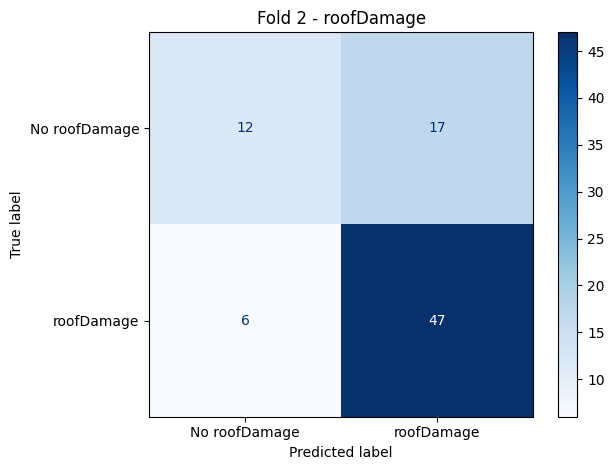

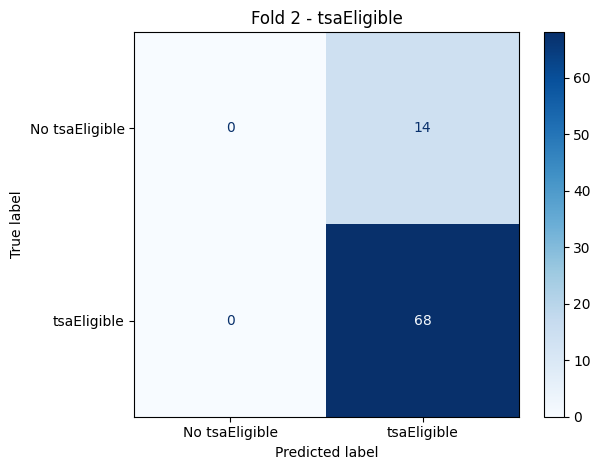

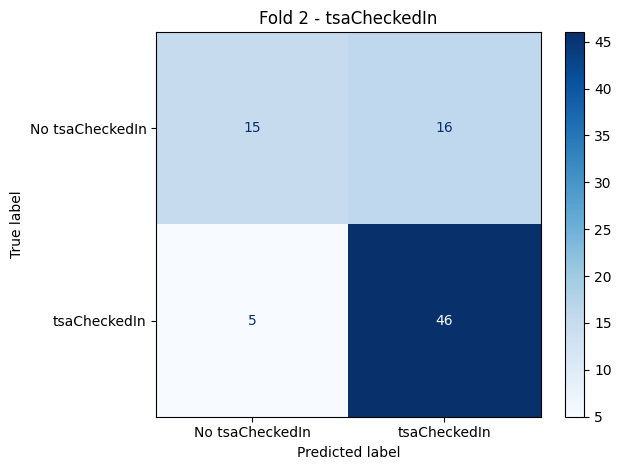

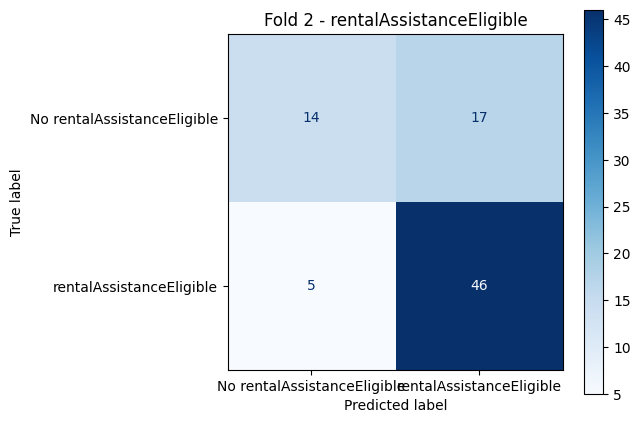

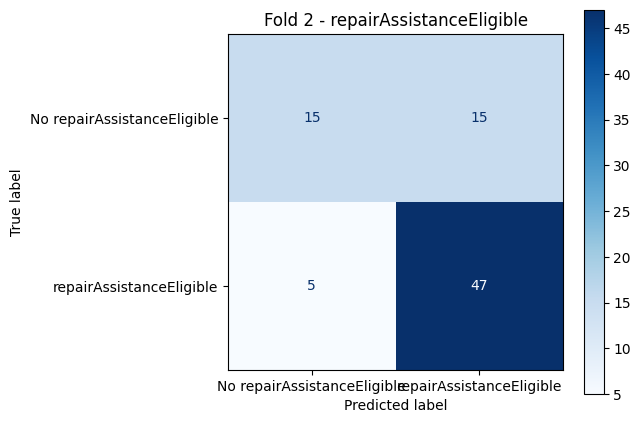

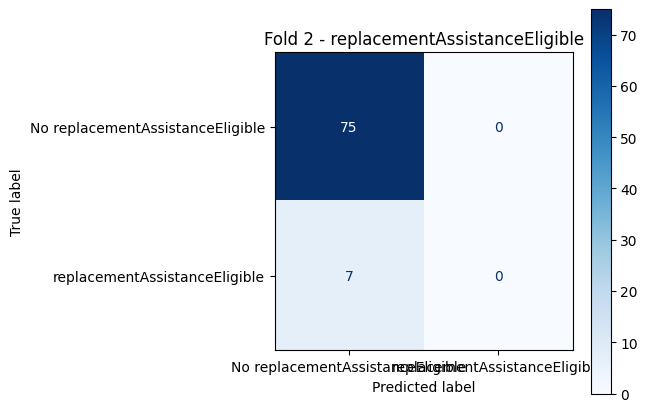

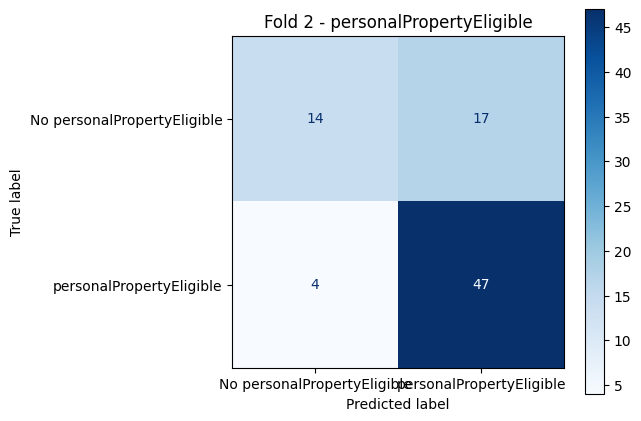


Evaluating fold 3...


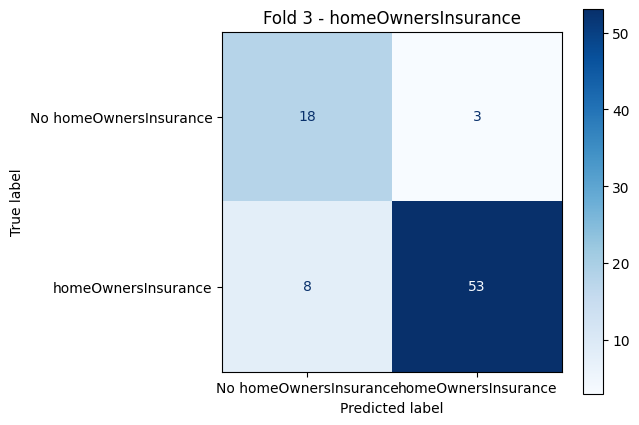

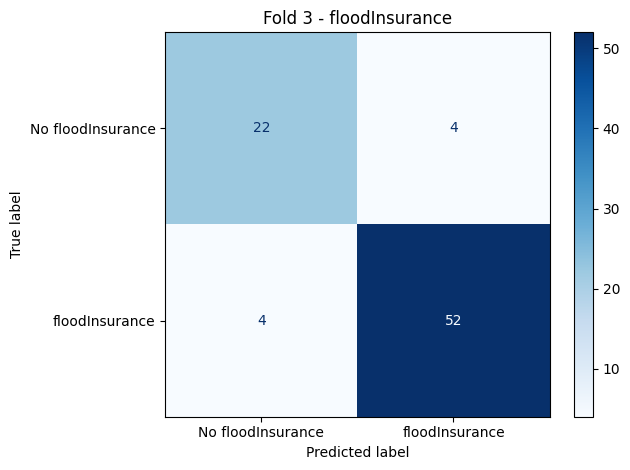

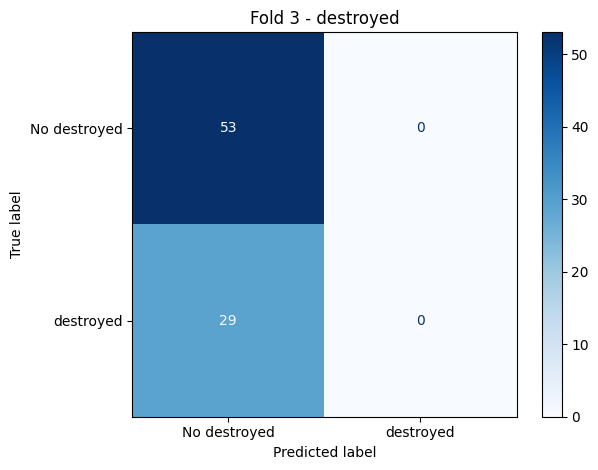

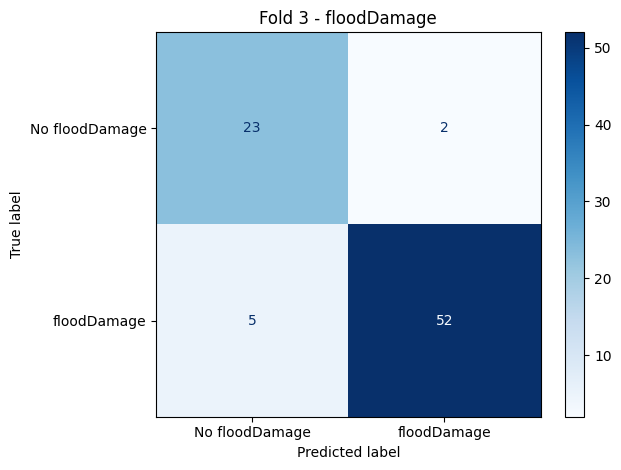

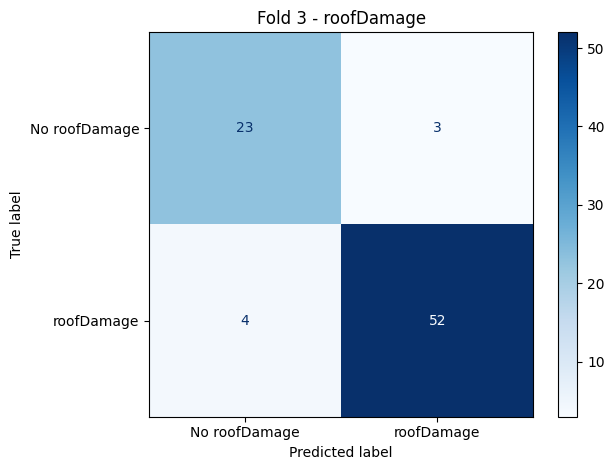

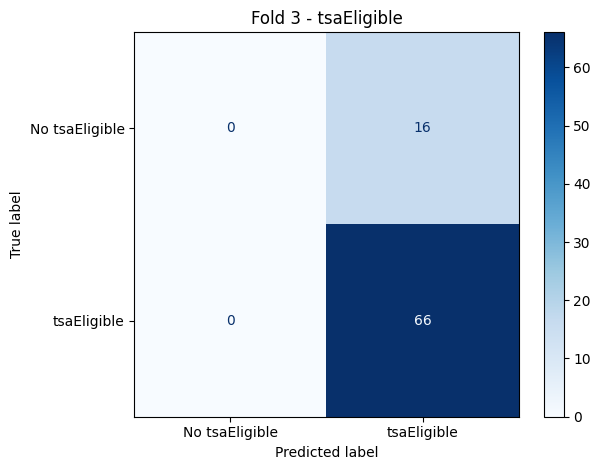

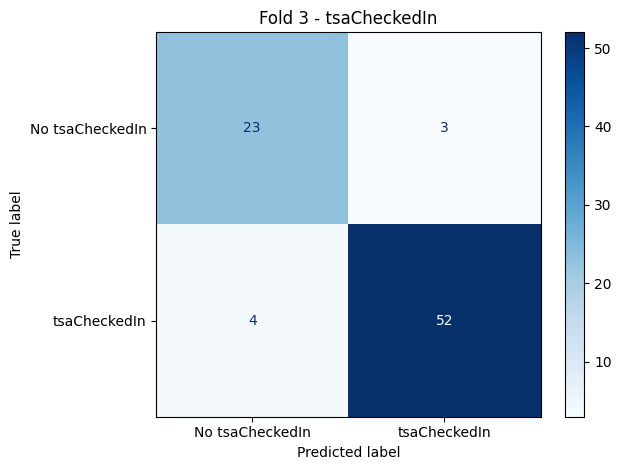

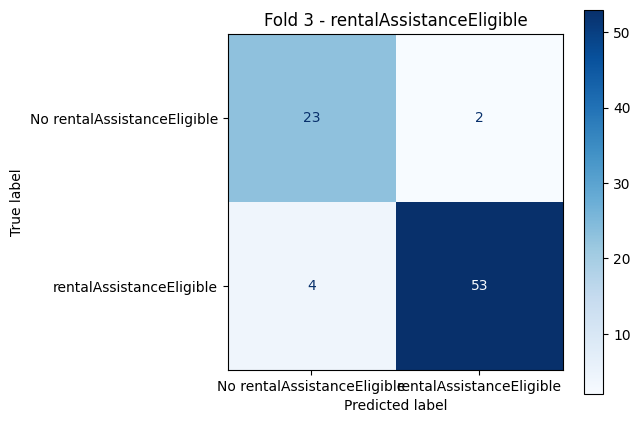

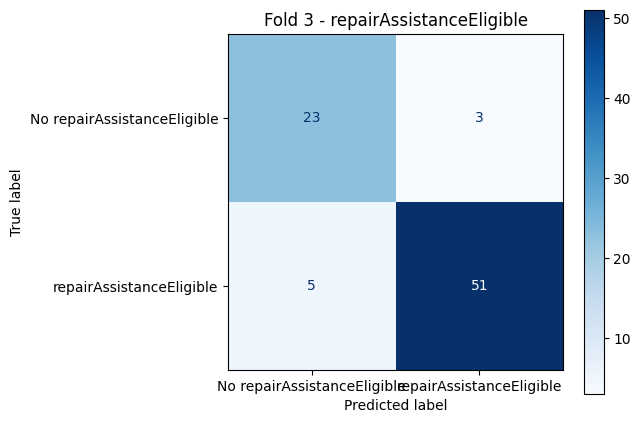

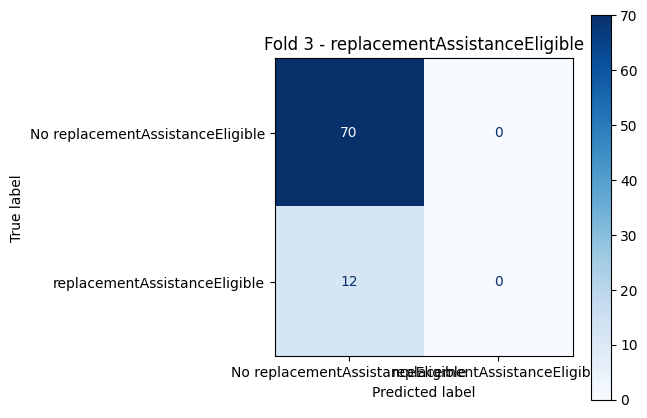

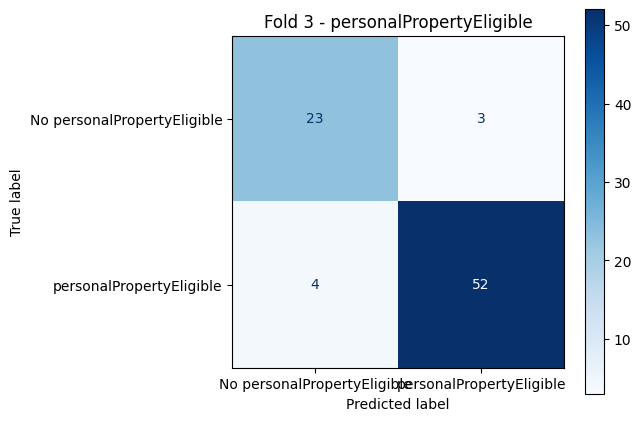


Evaluating fold 4...


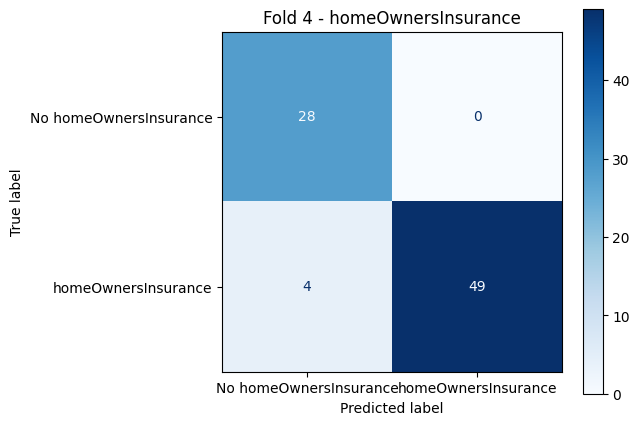

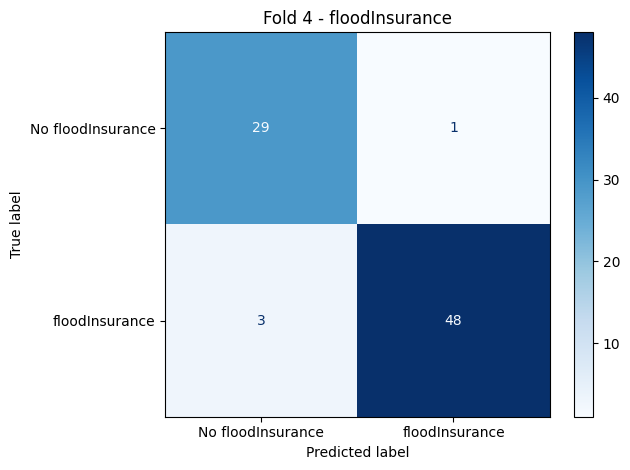

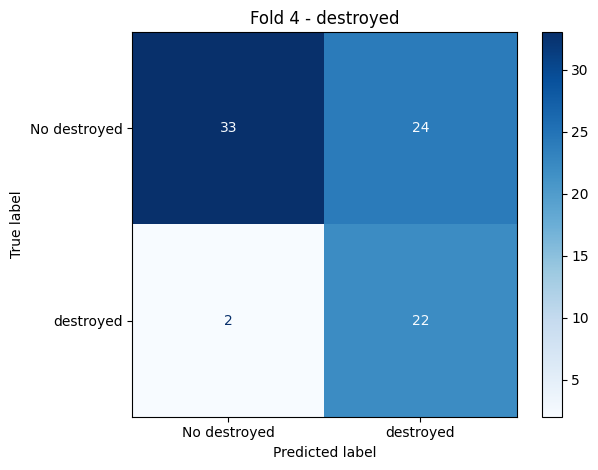

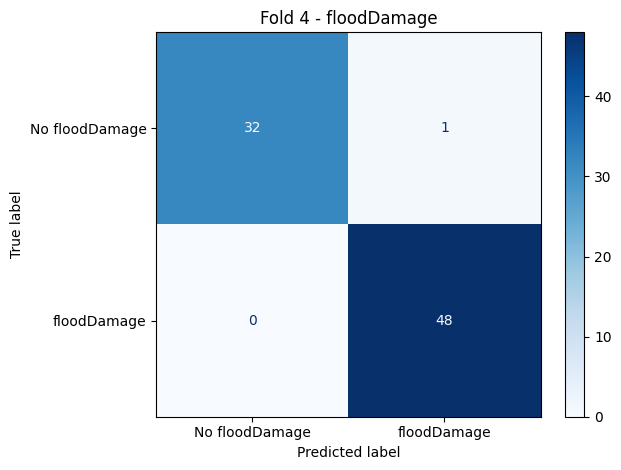

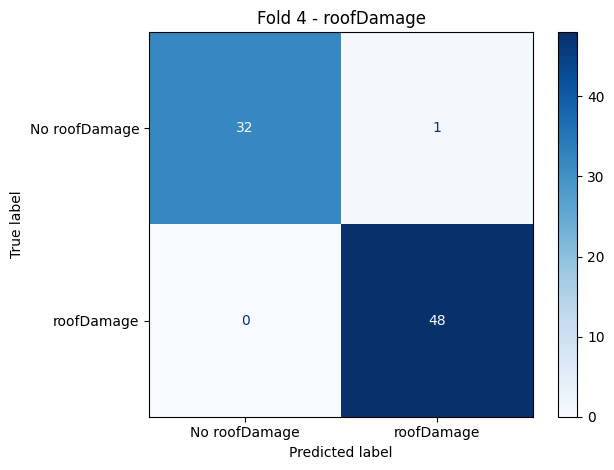

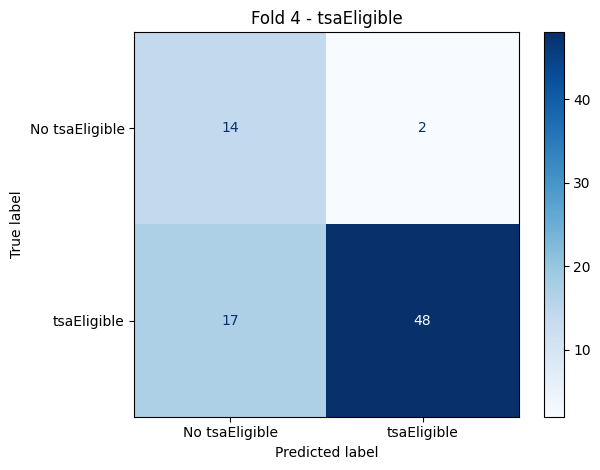

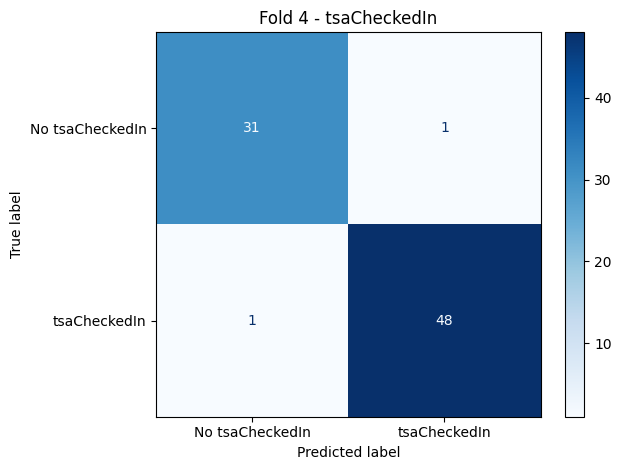

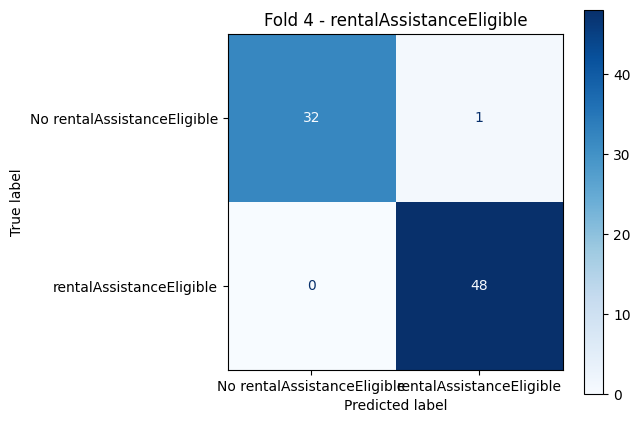

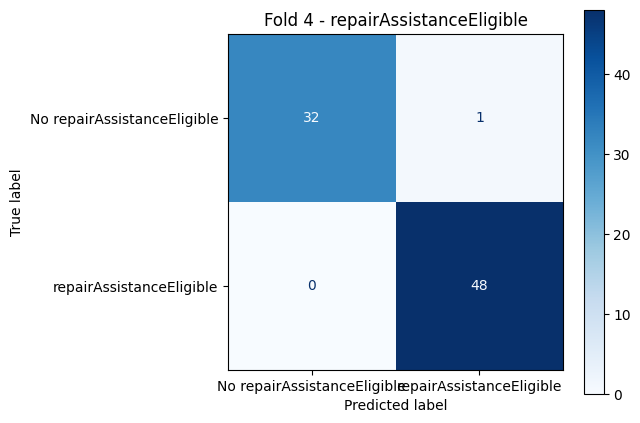

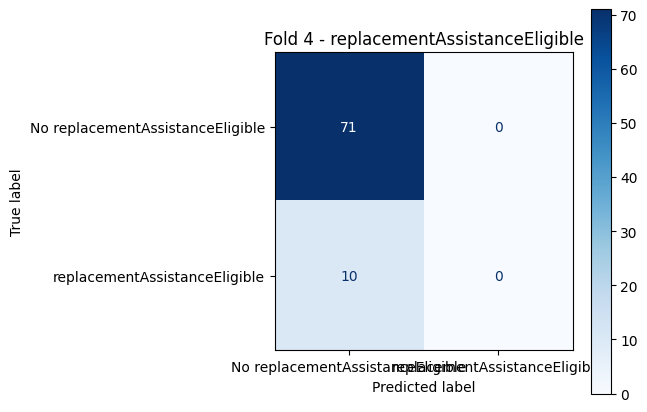

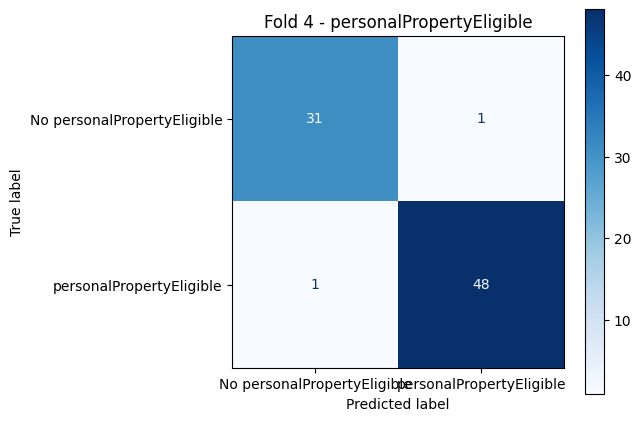


Evaluating fold 5...


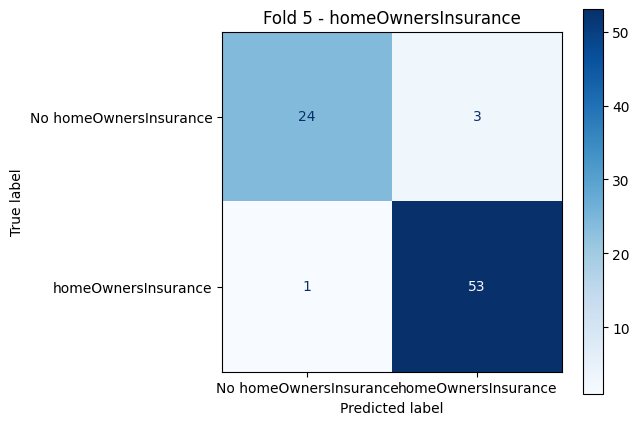

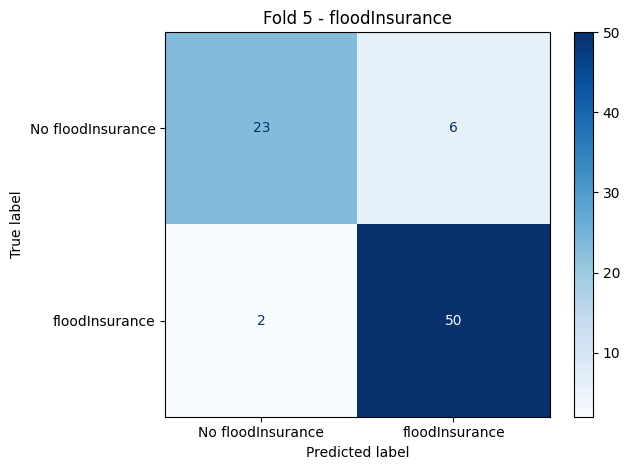

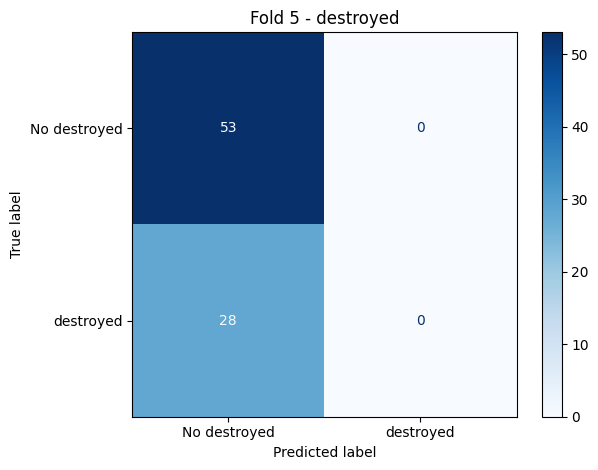

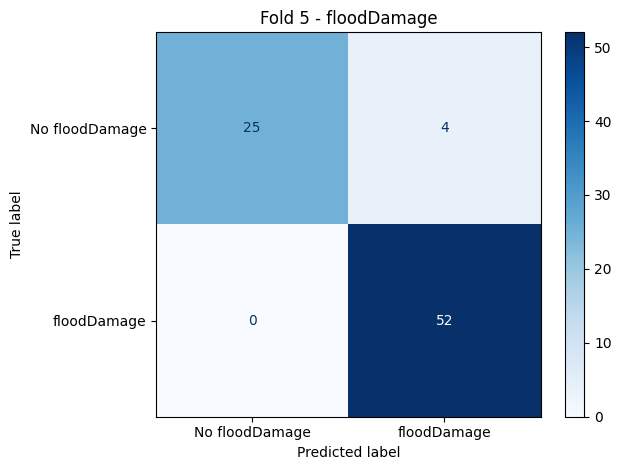

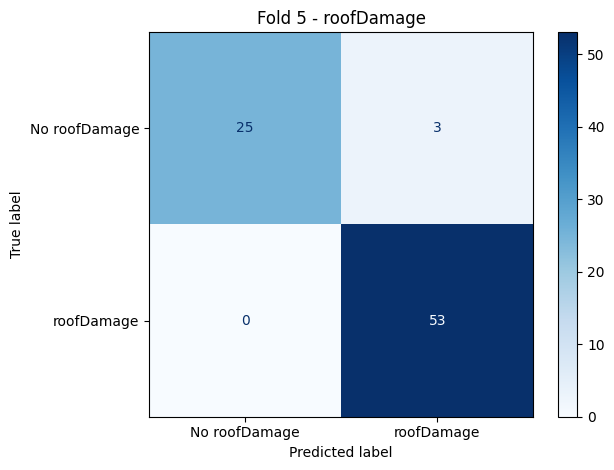

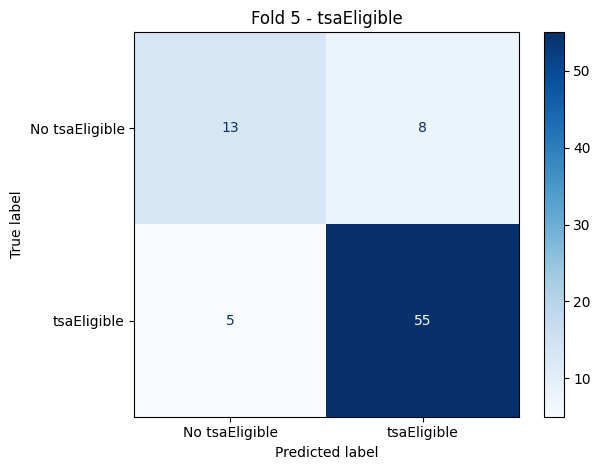

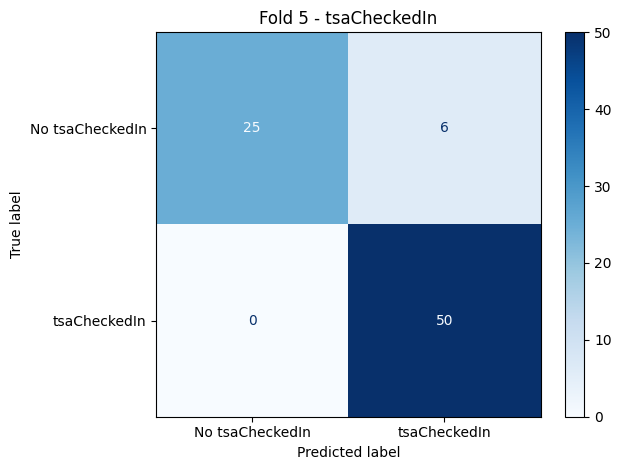

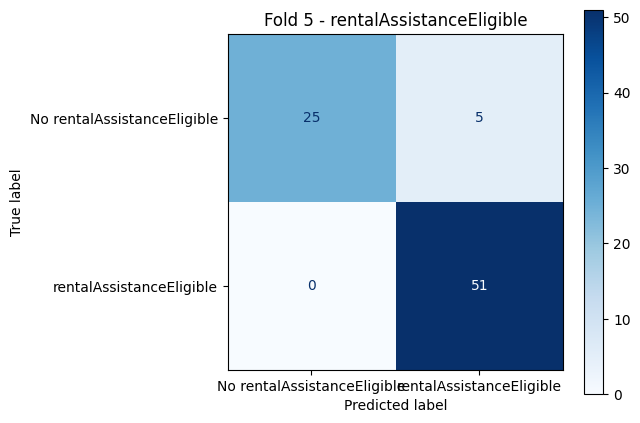

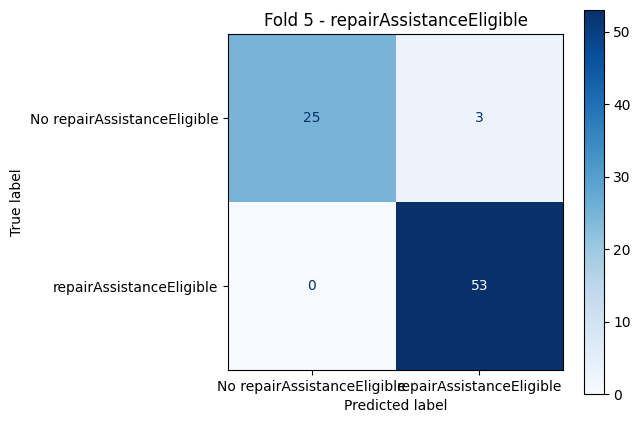

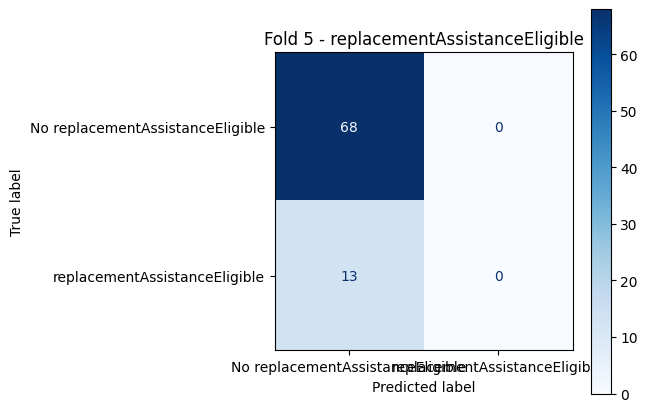

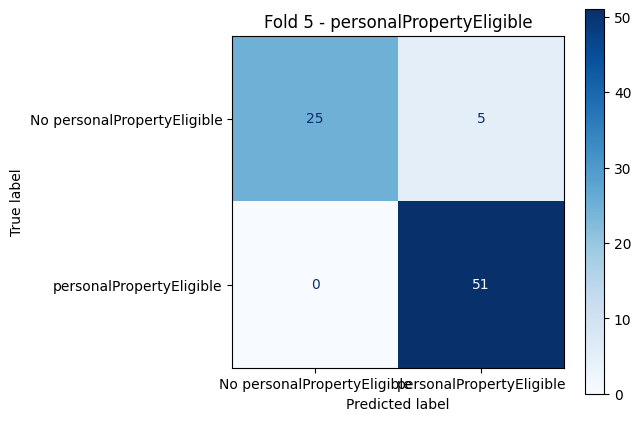

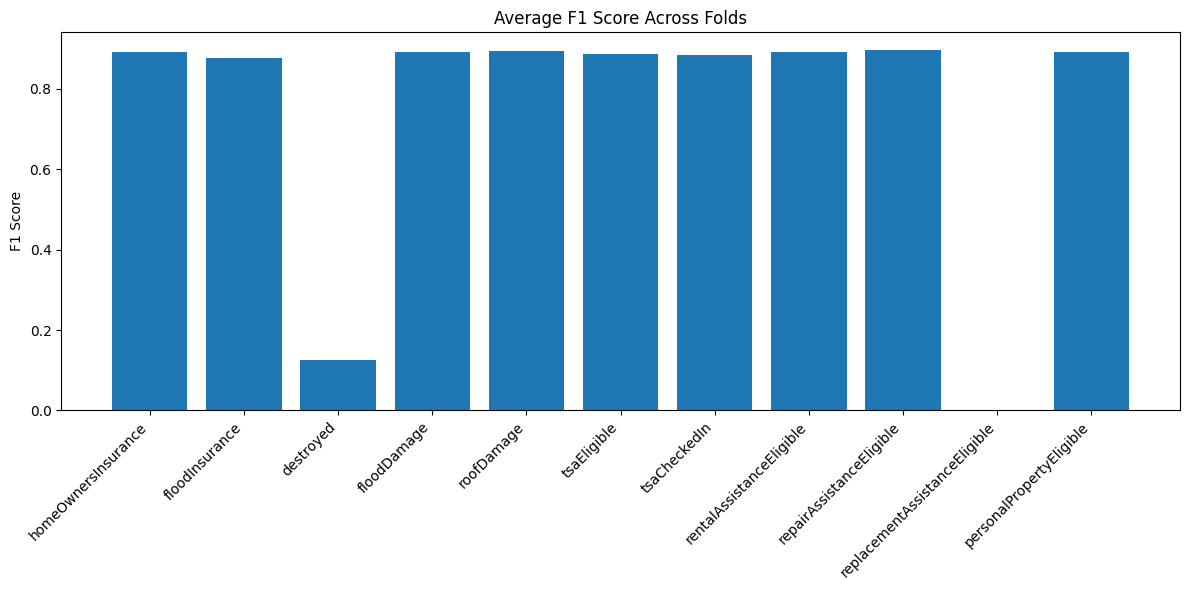

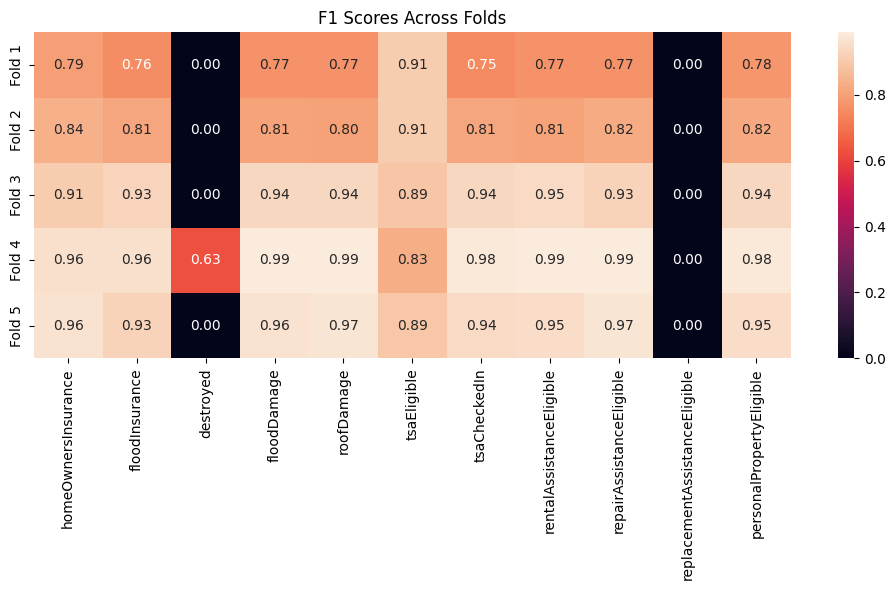

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_visualize(save_path, tweet_grouped, target_grouped, max_len=512):
    target_list = get_target_list()
    tweet_dict = {int(name): group['text'] for name, group in tweet_grouped}
    target_dict = {int(name): group[target_list] for name, group in target_grouped}

    intersecting_zips = list(set(tweet_dict.keys()) & set(target_dict.keys()))
    paired_data = {
        zipc: [target_dict[zipc].sum().apply(lambda x: 1 if x > 0 else 0), tweet_dict[zipc]]
        for zipc in intersecting_zips
    }

    texts = ['\n'.join(v[1].to_list()) for v in paired_data.values()]
    labels_ = [v[0] for v in paired_data.values()]
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    all_f1s, all_precisions, all_recalls = [], [], []

    for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(texts, labels_)):
        print(f"\nEvaluating fold {fold_idx + 1}...")

        model = BERTMultiDeepHeadClassifier(num_targets=len(target_list)).to(device)
        model_path = os.path.join(save_path, f"bert_model_fold_{fold_idx + 1}.pth")
        model.load_state_dict(torch.load(model_path))
        model.eval()

        test_texts = [texts[i] for i in test_idx]
        test_labels = [labels_[i] for i in test_idx]
        test_loader = DataLoader(CustomDataset(test_texts, test_labels, tokenizer, max_len), batch_size=16)

        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        preds = (np.vstack(all_preds) > 0.5).astype(int)
        true = np.vstack(all_labels)

        # Calculate metrics
        f1 = [f1_score(true[:, i], preds[:, i], zero_division=0) for i in range(len(target_list))]
        precision = [precision_score(true[:, i], preds[:, i], zero_division=0) for i in range(len(target_list))]
        recall = [recall_score(true[:, i], preds[:, i], zero_division=0) for i in range(len(target_list))]

        all_f1s.append(f1)
        all_precisions.append(precision)
        all_recalls.append(recall)

        # Confusion matrices
        conf_matrices = multilabel_confusion_matrix(true, preds)
        for i, cm in enumerate(conf_matrices):
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'No {target_list[i]}', f'{target_list[i]}'])
            disp.plot(cmap='Blues')
            plt.title(f'Fold {fold_idx + 1} - {target_list[i]}')
            plt.tight_layout()
            plt.show()

    # Summary plots
    all_f1s = np.array(all_f1s)
    avg_f1 = all_f1s.mean(axis=0)

    plt.figure(figsize=(12, 6))
    plt.bar(target_list, avg_f1)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('F1 Score')
    plt.title('Average F1 Score Across Folds')
    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(all_f1s, annot=True, fmt=".2f", xticklabels=target_list, yticklabels=[f"Fold {i+1}" for i in range(5)])
    plt.title("F1 Scores Across Folds")
    plt.tight_layout()
    plt.show()

# Run evaluation
evaluate_and_visualize(save_path, tweet_grouped_harvey, target_grouped_harvey, max_len=512)

- Loads saved models from each fold
- Computes and visualizes:
  - Confusion matrices for each label
  - Bar plot of average F1 scores
  - Heatmap of F1 scores across folds
- Helps analyze model performance per label and consistency across folds